<div style="border: 5px solid purple; padding: 10px; margin: 5px">
<b> Svetlana's comment  </b>
    

Hi Taylor, my name is Svetlana (https://hub.tripleten.com/u/6dee602c).


Thank you for submitting such a great plan! It has everything you need, so you can move on to the code part! :) 

</div>

# Introduction

**Interconnect** is a telecom provider that offers home phone service (single or multiple lines) and internet access (DSL or fiber), plus add-ons like online security, backups, tech support, and streaming. The business challenge is **customer churn**: when a subscriber is likely to leave, the team wants to reach out with promos or plan tweaks before that happens.

**Our goal** is to build a model that flags customers at risk of churn so marketing can prioritize retention efforts. We’ll judge success primarily by **AUC-ROC** (with Accuracy as a secondary check) and deliver clear, practical insights the team can act on—e.g., who to contact first and which plan/features tend to be associated with higher churn.


## 1) Data Loading & Structure Check

**Files (join on `customerID`):**
- `contract.csv` — contract info (includes `BeginDate`, `EndDate`, `PaymentMethod`, etc.)
- `personal.csv` — demographics
- `internet.csv` — internet plan/features
- `phone.csv` — phone plan/features

**Plan:**
- Read all four from `/datasets/final_provider/`
- Left-join on `customerID` to build one modeling table
- Quick sanity checks: `.shape`, `.head()`, `.info()`, missing values, duplicate `customerID`s



In [6]:
# Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", 100)


In [7]:
# Load data files

DATA_DIR = Path("/datasets/final_provider")

contract = pd.read_csv(DATA_DIR / "contract.csv")
personal = pd.read_csv(DATA_DIR / "personal.csv")
internet = pd.read_csv(DATA_DIR / "internet.csv")
phone    = pd.read_csv(DATA_DIR / "phone.csv")

# Merge on customerID to build one table
df = (
    contract
    .merge(personal, on="customerID", how="left")
    .merge(internet, on="customerID", how="left")
    .merge(phone,    on="customerID", how="left")
)

print("Shapes:")
print("  contract:", contract.shape)
print("  personal:", personal.shape)
print("  internet:", internet.shape)
print("  phone   :", phone.shape)
print("  merged  :", df.shape)

df.head()


Shapes:
  contract: (7043, 8)
  personal: (7043, 5)
  internet: (5517, 8)
  phone   : (6361, 2)
  merged  : (7043, 20)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [8]:
# Quick EDA & sanity checks

# Dtypes / nulls
display(df.info())
display(df.isna().sum().sort_values(ascending=False).head(15))

# Make sure numeric columns are numeric
df['MonthlyCharges'] = pd.to_numeric(df['MonthlyCharges'], errors='coerce')
df['TotalCharges']   = pd.to_numeric(df['TotalCharges'],   errors='coerce')

# Basic distributions
display(df[['MonthlyCharges','TotalCharges']].describe())

# Key categoricals snapshot
for col in ['Type','PaymentMethod','InternetService','MultipleLines','OnlineSecurity','StreamingTV']:
    print(f"\n{col} ({df[col].nunique()} unique)")
    print(df[col].value_counts(dropna=False).head(10))

# Target column raw values (as provided)
print("\nEndDate values:")
print(df['EndDate'].value_counts(dropna=False))


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

StreamingMovies     1526
StreamingTV         1526
TechSupport         1526
DeviceProtection    1526
OnlineBackup        1526
OnlineSecurity      1526
InternetService     1526
MultipleLines        682
BeginDate              0
Dependents             0
customerID             0
SeniorCitizen          0
gender                 0
TotalCharges           0
MonthlyCharges         0
dtype: int64

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000



Type (3 unique)
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

PaymentMethod (4 unique)
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

InternetService (2 unique)
Fiber optic    3096
DSL            2421
NaN            1526
Name: InternetService, dtype: int64

MultipleLines (2 unique)
No     3390
Yes    2971
NaN     682
Name: MultipleLines, dtype: int64

OnlineSecurity (2 unique)
No     3498
Yes    2019
NaN    1526
Name: OnlineSecurity, dtype: int64

StreamingTV (2 unique)
No     2810
Yes    2707
NaN    1526
Name: StreamingTV, dtype: int64

EndDate values:
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64


In [9]:
# Minimal prep for modeling preview

# Parse dates
df['BeginDate'] = pd.to_datetime(df['BeginDate'], errors='coerce')
# EndDate is 'No' for active customers; leave as string for target, but make a parsed copy for tenure calc
_end = pd.to_datetime(df['EndDate'], errors='coerce')

# Dataset is valid as of 2020-02-01; use that to compute tenure for active customers
asof = pd.Timestamp('2020-02-01')
end_for_tenure = _end.fillna(asof)

# Tenure in months (approx)
df['tenure_months'] = ((end_for_tenure - df['BeginDate']).dt.days / 30.44).round(1)

# Binary target:
# Per project note, the target is EndDate == 'No' (active). 
# If you prefer "churned" as 1, i'll just flip this later.
df['target_active'] = (df['EndDate'] == 'No').astype(int)

print("\nClass balance (active vs not):")
print(df['target_active'].value_counts(normalize=True).rename({1:'active',0:'not active'}))

# Quick look at missingness for service columns (often NaN = not subscribed)
service_cols = ['InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
                'TechSupport','StreamingTV','StreamingMovies','MultipleLines']
print("\nService columns missing values:")
print(df[service_cols].isna().sum())



Class balance (active vs not):
active        0.73463
not active    0.26537
Name: target_active, dtype: float64

Service columns missing values:
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64


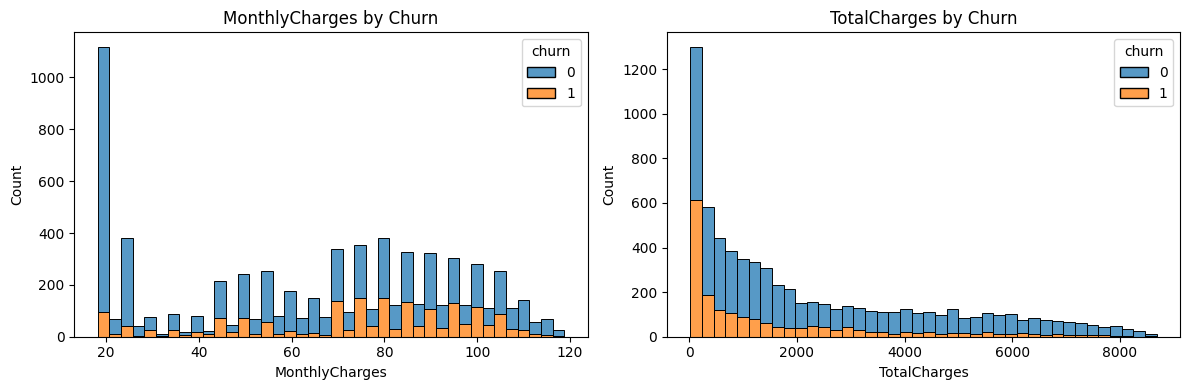

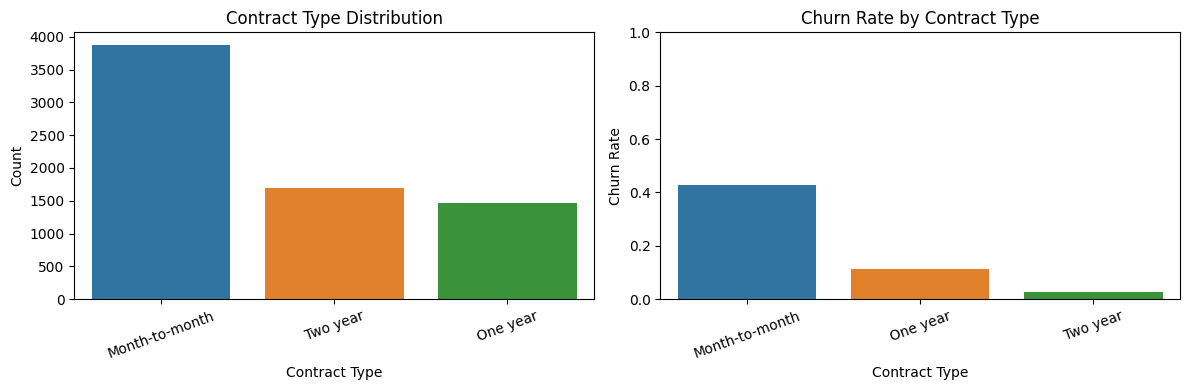

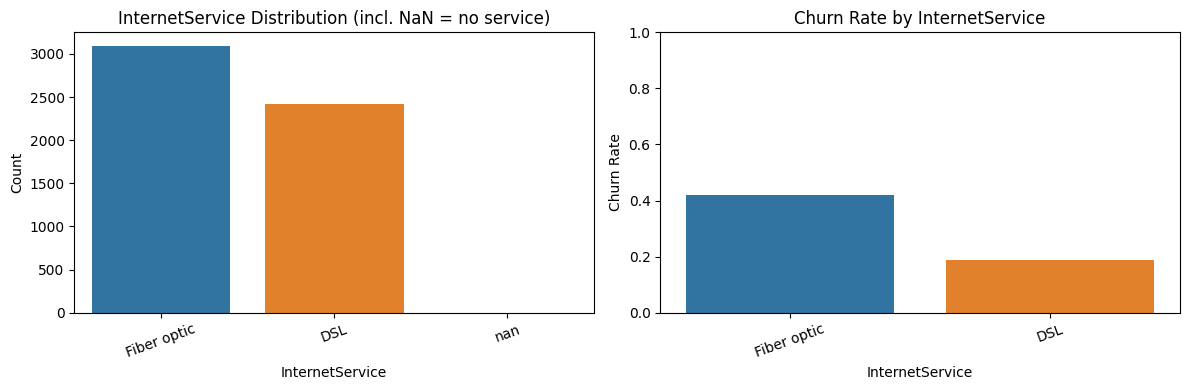

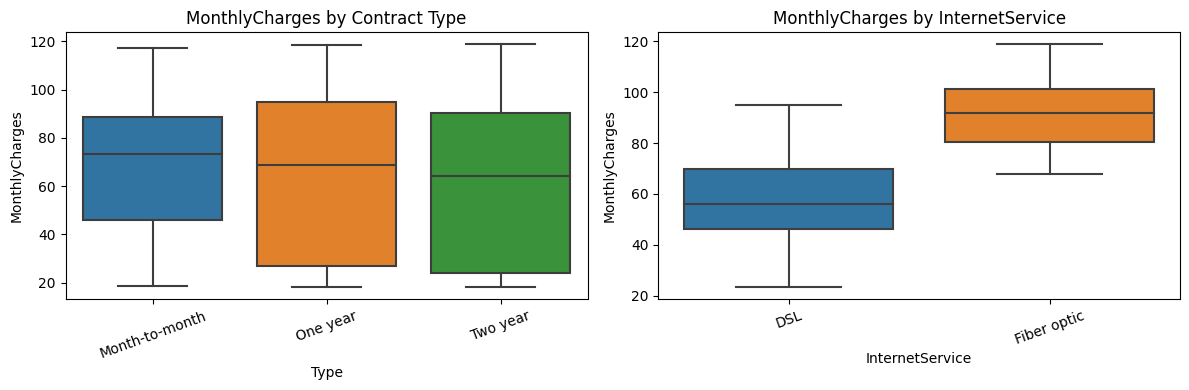

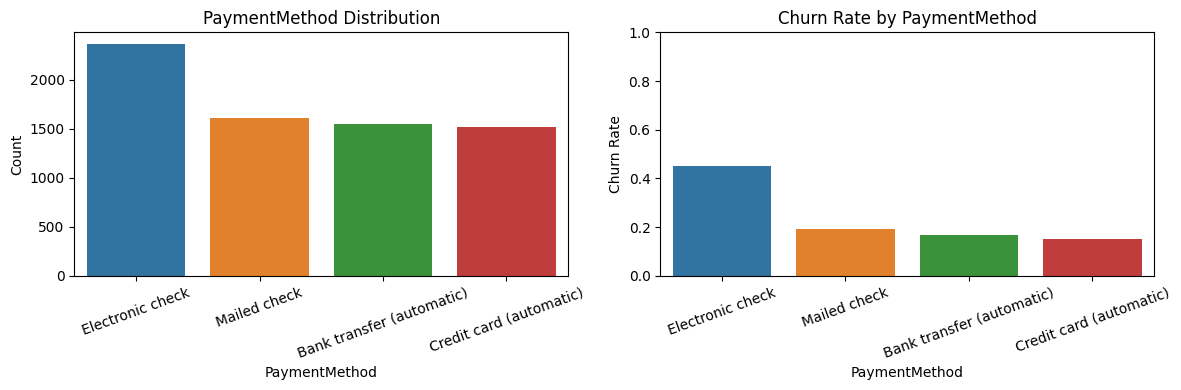

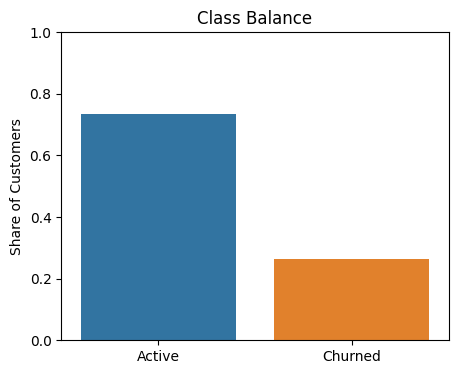

In [10]:
# --- Quick EDA visualizations for churn project ---


# Clean a few fields and create a churn target
df = df.copy()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['churn'] = (df['EndDate'] != 'No').astype(int)

# ---- 1) Distributions of numeric charges (overall vs churn) ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df, x='MonthlyCharges', hue='churn', multiple='stack', bins=40, ax=axes[0])
axes[0].set_title('MonthlyCharges by Churn')
axes[0].set_ylabel('Count')

sns.histplot(df.dropna(subset=['TotalCharges']), x='TotalCharges', hue='churn',
             multiple='stack', bins=40, ax=axes[1])
axes[1].set_title('TotalCharges by Churn')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

# ---- 2) Contract mix + churn rate by contract ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=df, x='Type', ax=axes[0], order=df['Type'].value_counts().index)
axes[0].set_title('Contract Type Distribution')
axes[0].set_xlabel('Contract Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=20)

churn_by_contract = df.groupby('Type')['churn'].mean().sort_values(ascending=False)
sns.barplot(x=churn_by_contract.index, y=churn_by_contract.values, ax=axes[1])
axes[1].set_title('Churn Rate by Contract Type')
axes[1].set_ylabel('Churn Rate')
axes[1].set_xlabel('Contract Type')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

# ---- 3) Internet service mix + churn by internet service ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=df, x='InternetService', ax=axes[0],
              order=df['InternetService'].value_counts(dropna=False).index)
axes[0].set_title('InternetService Distribution (incl. NaN = no service)')
axes[0].set_xlabel('InternetService')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=20)

churn_by_net = df.groupby('InternetService')['churn'].mean().sort_values(ascending=False)
sns.barplot(x=churn_by_net.index.astype(str), y=churn_by_net.values, ax=axes[1])
axes[1].set_title('Churn Rate by InternetService')
axes[1].set_ylabel('Churn Rate')
axes[1].set_xlabel('InternetService')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

# ---- 4) Boxplots: MonthlyCharges by contract & by internet service ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.boxplot(data=df, x='Type', y='MonthlyCharges', ax=axes[0])
axes[0].set_title('MonthlyCharges by Contract Type')
axes[0].tick_params(axis='x', rotation=20)

sns.boxplot(data=df, x='InternetService', y='MonthlyCharges', ax=axes[1])
axes[1].set_title('MonthlyCharges by InternetService')
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

# ---- 5) Payment method: distribution + churn rate ----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(data=df, x='PaymentMethod', ax=axes[0],
              order=df['PaymentMethod'].value_counts().index)
axes[0].set_title('PaymentMethod Distribution')
axes[0].set_xlabel('PaymentMethod')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=20)

churn_by_pay = df.groupby('PaymentMethod')['churn'].mean().sort_values(ascending=False)
sns.barplot(x=churn_by_pay.index, y=churn_by_pay.values, ax=axes[1])
axes[1].set_title('Churn Rate by PaymentMethod')
axes[1].set_ylabel('Churn Rate')
axes[1].set_xlabel('PaymentMethod')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

# ---- 6) Quick class balance chart ----
plt.figure(figsize=(5, 4))
sns.barplot(x=['Active','Churned'],
            y=[(df['churn']==0).mean(), (df['churn']==1).mean()])
plt.title('Class Balance')
plt.ylabel('Share of Customers')
plt.ylim(0, 1)
plt.show()


## Exploratory Data Analysis (EDA) — Visual Insights

### 1. MonthlyCharges and TotalCharges by Churn
- **Observation**: Customers who **churn** tend to have **higher MonthlyCharges** compared to those who stayed.
- **TotalCharges** is more spread out, and many churners are clustered toward the **lower end** of total charges — suggesting newer customers with shorter lifetimes tend to churn more.

---

### 2. Contract Type Distribution and Churn Rate
- **Most common contract**: "Month-to-month"
- **Churn insights**:
  - Customers on **Month-to-month** contracts churn **much more frequently**.
  - Those with **1 or 2-year contracts** have significantly **lower churn rates**, likely due to commitment duration and discounts.

---

### 3. Internet Service Type and Churn Rate
- **Types**: DSL, Fiber optic, and No service.
- **Churn rates**:
  - **Fiber optic users** have the **highest churn rate**, possibly due to higher costs or aggressive competitors.
  - Customers with **no internet service** have very **low churn**, potentially indicating lower-cost or legacy plans.

---

### 4. Monthly Charges by Contract Type and Internet Service
- **Contract Type**:
  - **Month-to-month** contracts have a **wider spread** and **higher median MonthlyCharges**.
- **Internet Service**:
  - **Fiber optic** plans clearly have **higher monthly costs**, which aligns with their higher churn rate.
  - DSL plans are cheaper and more stable in cost.

---

### 5. Payment Method Distribution and Churn Rate
- **Most common**: Electronic check.
- **Churn insights**:
  - Customers using **Electronic checks** churn **more than other methods**.
  - **Bank transfers and credit card automatic payments** are associated with **lower churn**, likely due to automation and stability.

---

### 6. Class Imbalance: Churn vs. Active
- The dataset is **imbalanced**:
  - Roughly **26.5% of customers have churned**, while **73.5% are still active**.


---


## Questions I Need to Clarify

Before diving into deeper analysis and modeling, there are a few things I need to get clearer on:

1. **What time period does this dataset cover?**  
   - The `EndDate` column suggests customer churn data goes up to around Jan 2020, but is this data current as of that month, or is there more recent info we’re missing?

2. **How exactly is churn defined?**  
   - Right now, I’m assuming anyone with an `EndDate` that’s *not* "No" has churned. Is that the correct logic, or is there more to it (like checking contract status or activity)?

3. **Are missing service values actually missing, or just “No”?**  
   - For example, if a customer doesn’t have internet service, should all the internet-related features be filled with “No” or left blank (`NaN`)?

4. **Can I drop or fill in columns with a lot of missing data?**  
   - Some columns like `StreamingTV` and `MultipleLines` have missing values — should I keep those and try to infer them, or is it okay to remove them?

5. **Is the only goal to predict churn, or are there other things we care about?**  
   - Like, are we also supposed to look into customer segments, revenue trends, or anything else besides just “will this person churn?”

6. **Do I need to balance the churn classes?**  
   - If the dataset is imbalanced (like 70% stayed and 30% left), should I apply techniques like SMOTE or undersampling, or is it okay to leave it as-is?

7. **Why is `TotalCharges` an object instead of a number?**  
   - Should I convert it to a numeric column (and clean it), or is there a reason it’s stored as a string?

8. **Are there any sensitive features I shouldn’t use in modeling?**  
   - I noticed columns like `gender` and `SeniorCitizen`. Are these okay to include in the model, or should I leave them out for ethical/regulatory reasons?

Getting these questions answered will help me stay on track with the project and avoid doing something outside the scope or against the rules.



## Project Plan: Predicting Customer Churn


### 1. Data Preprocessing
Clean and prepare the data for analysis. This includes handling missing values, correcting data types (e.g., converting `TotalCharges` to numeric), and encoding categorical features.

### 2. Exploratory Data Analysis (EDA)
Visualize and summarize the data to identify trends, correlations, and possible indicators of churn. Look into distributions of charges, service usage, and customer demographics.

### 3. Feature Engineering
Create or transform features that may help improve model performance. This may involve generating binary flags (e.g., `has_internet_service`), customer tenure in months, or encoding contract types.

### 4. Model Building
Train multiple machine learning models to predict churn (e.g., logistic regression, decision trees, random forest). Evaluate them using cross-validation and performance metrics like AUC-ROC and accuracy.

### 5. Model Evaluation and Interpretation
Select the best model and interpret the results. Analyze feature importance and how each factor influences churn. Address any model fairness or bias issues as needed


_Ready for Stage 1 review — feedback welcome before moving on to Stage 2._
